# What factors influence Salary?

From a Kaggle Dataset: https://www.kaggle.com/datasets/rkiattisak/salaly-prediction-for-beginer/data

This project explores salary prediction using real-world data. After cleaning and preprocessing the data, I applied multiple regression techniques and a Random Forest model to identify which features most significantly influence salary. SHAP values were used to explain individual predictions and ensure model transparency. I also evaluated potential fairness issues by examining the impact of gender on model predictions.

This notebook explores which factors most significantly influence salary, using data preprocessing, visualization, and a combination of supervised and unsupervised modeling techniques to answer the overarching question:

What factors most influence salary, and how can we accurately predict salary using machine learning models?

## Import Libraries

In [1]:
# General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
import shap

In [60]:
# Modeling
from sklearn.linear_model import LinearRegression, LassoCV, Ridge, Lasso
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Prepare dataset

### Explore Salary Dataset

In [3]:
# Read in dataset and check dataframe
salary = pd.read_csv('Salary Data.csv')
salary.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [4]:
# Explore Data
salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  373 non-null    float64
 1   Gender               373 non-null    object 
 2   Education Level      373 non-null    object 
 3   Job Title            373 non-null    object 
 4   Years of Experience  373 non-null    float64
 5   Salary               373 non-null    float64
dtypes: float64(3), object(3)
memory usage: 17.7+ KB


In [5]:
# Explore Data
salary.describe()

,Age,Years of Experience,Salary
count,373.000000,373.000000,373.000000
mean,37.431635,10.030831,100577.345845
std,7.069073,6.557007,48240.013482
min,23.000000,0.000000,350.000000
25%,31.000000,4.000000,55000.000000
50%,36.000000,9.000000,95000.000000
75%,44.000000,15.000000,140000.000000
max,53.000000,25.000000,250000.000000


In [6]:
# find any rows with NA values and drop them
print(salary[salary.isna().any(axis=1)])
salary_clean = salary.dropna()

     Age Gender Education Level Job Title  Years of Experience  Salary
172  NaN    NaN             NaN       NaN                  NaN     NaN
260  NaN    NaN             NaN       NaN                  NaN     NaN


In [67]:
# Check average salary per education level
round(salary_clean.groupby(['Education Level'])['Salary'].mean(), 2).reset_index()

,Education Level,Salary
0,Bachelor's,74756.03
1,Master's,129795.92
2,PhD,157843.14


To evaluate whether salary varies significantly across education levels, I conducted a one-way ANOVA test. The results showed a statistically significant difference in average salary between at least two education groups (p < 0.05), leading me to reject the null hypothesis that all group means are equal.

To identify which groups differed, I performed a Tukey’s HSD post-hoc test for pairwise comparisons. The test revealed that all pairs of education levels (Bachelor's, Master's, PhD) had statistically significant salary differences, confirming that each higher level of education was associated with a meaningful increase in salary.

In [59]:
# rename column
salary_clean2 = salary_clean.rename(columns={'Education Level': 'Education_Level'})

# Fit the model
model = ols('Salary ~ C(Education_Level)', data=salary_clean2).fit()

# Perform one-way ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                          sum_sq     df           F        PR(>F)
C(Education_Level)  4.002628e+11    2.0  159.101351  1.379717e-50
Residual            4.654180e+11  370.0         NaN           NaN


In [62]:
# Tukey's HSD for pairwise comparisons
tukey = pairwise_tukeyhsd(endog=salary_clean2['Salary'],
                          groups=salary_clean2['Education_Level'],
                          alpha=0.05)

print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1    group2   meandiff  p-adj   lower      upper    reject
-----------------------------------------------------------------
Bachelor's Master's 55039.8916   0.0 44931.8392  65147.944   True
Bachelor's      PhD 83087.1105   0.0 70138.1816 96036.0393   True
  Master's      PhD 28047.2189   0.0 13636.9659 42457.4718   True
-----------------------------------------------------------------


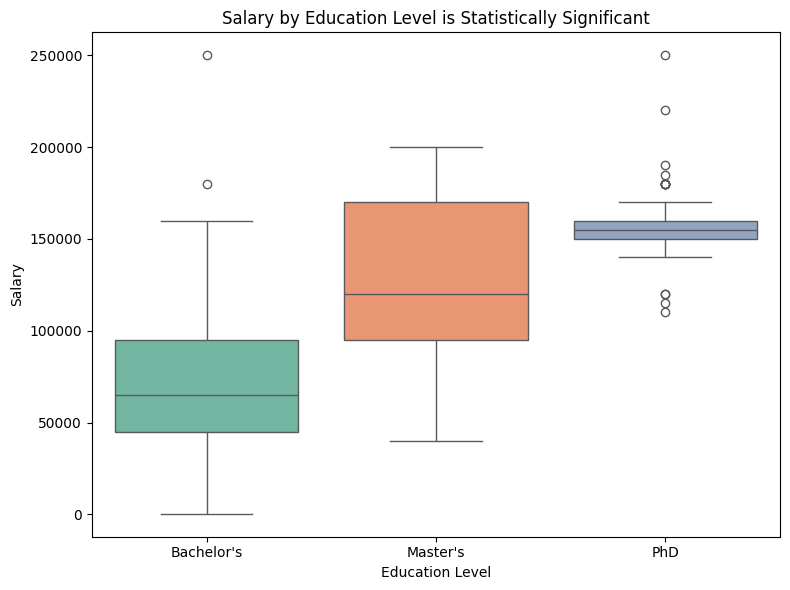

In [69]:
# Basic boxplot
plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=salary_clean, x='Education Level', y='Salary', hue = 'Education Level', palette='Set2', dodge=False)

# Add manual significance annotations from Tukey HSD
# Use y positions above your max box height
y_max = salary_clean['Salary'].max()
y_offset = 5000

plt.title("Salary by Education Level is Statistically Significant")
plt.ylabel("Salary")
plt.xlabel("Education Level")
plt.tight_layout()
plt.show()


Use OneHotEncoder to transform columns in NA-dropped dataframe into a new binary feature (0 or 1).

In [7]:
# Columns to encode
categorical_cols = ['Gender', 'Education Level']

# Initialize encoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform
encoded_array = encoder.fit_transform(salary_clean[categorical_cols])

# Get new column names
encoded_cols = encoder.get_feature_names_out(categorical_cols)

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols)

# Reset index to align rows
encoded_df.index = salary_clean.index

# Concat dataframes
df_encoded = pd.concat([salary_clean.drop(columns=categorical_cols), encoded_df], axis=1)
df_encoded.head()

,Age,Job Title,Years of Experience,Salary,Gender_Male,Education Level_Master's,Education Level_PhD
0,32.0,Software Engineer,5.0,90000.0,1.0,0.0,0.0
1,28.0,Data Analyst,3.0,65000.0,0.0,1.0,0.0
2,45.0,Senior Manager,15.0,150000.0,1.0,0.0,1.0
3,36.0,Sales Associate,7.0,60000.0,0.0,0.0,0.0
4,52.0,Director,20.0,200000.0,1.0,1.0,0.0


## Predicting Salary with Simple Linear Regression

Text(0.5, 1.0, 'Investigating the Relationship B/w Experience and Salary')

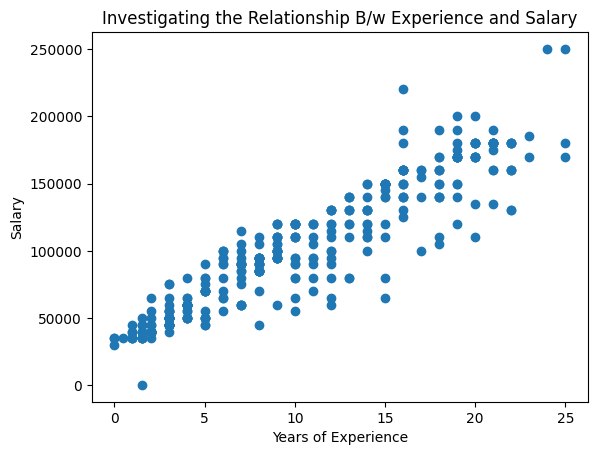

In [8]:
# Plot to see what Years of Experience and Salary look like
plt.scatter(df_encoded['Years of Experience'], df_encoded['Salary'])
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.title('Investigating the Relationship B/w Experience and Salary')

### Train/Test Split Data (only Years of Experience and Salary)

In [9]:
# Train/test data
X = df_encoded[['Years of Experience']]
y = df_encoded[['Salary']]

X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X, y, test_size=0.2, random_state=42)

### Train the Simple Linear Regression Model

In [10]:
# Train Model
model = LinearRegression()
model.fit(X_train_lin, y_train_lin)

LinearRegression()

### Evaluate Simple Linear Regression Model

R²: 0.8991338517367767
MSE: 241834883.8999349
MAE: 12094.170341194764
Intercept: [31521.07762021]
Coefficient: [6822.59017499]


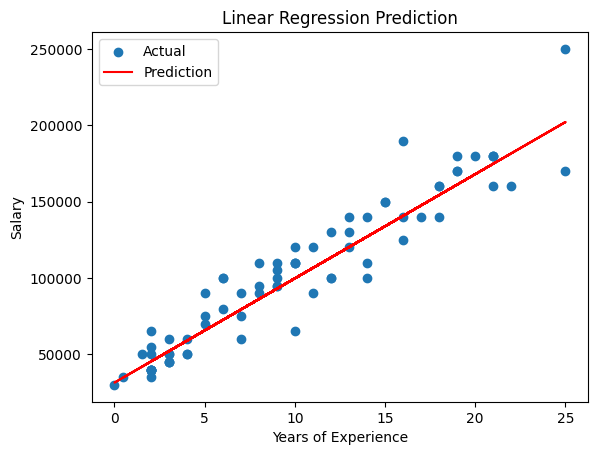

In [11]:
# Predict Model
y_pred_lin = model.predict(X_test_lin)

# Score
linear_r2_score = r2_score(y_test_lin, y_pred_lin)
linear_mae = mean_absolute_error(y_test_lin, y_pred_lin)
linear_rmse = rmse = np.sqrt(mean_squared_error(y_test_lin, y_pred_lin))
print("R²:", linear_r2_score)
print("MSE:", mean_squared_error(y_test_lin, y_pred_lin))
print("MAE:", linear_mae)
print(f"Intercept: {model.intercept_}")
print(f"Coefficient: {model.coef_[0]}")

# Plot
plt.scatter(X_test_lin, y_test_lin, label='Actual')
plt.plot(X_test_lin, y_pred_lin, color='red', label='Prediction')
plt.legend()
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.title("Linear Regression Prediction")
plt.show()

### Residual Plot to Assess Simple Linear Regression Model Performance

The residuals (errors) fan out as the predicted salary increases, which means that the model does okay for lower salaries but struggles with higher salary predictions. This indicates that there may be non-linear patterns or features missing.

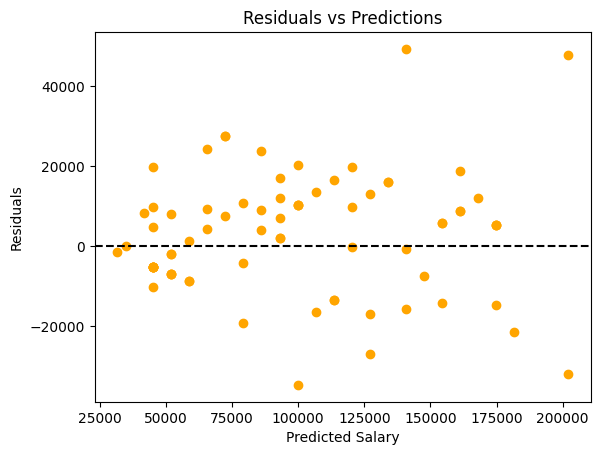

In [12]:
# Find Residuals
residuals_lin = y_test_lin - y_pred_lin

# Plot
plt.scatter(y_pred_lin, residuals_lin, color='orange')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Salary')
plt.ylabel('Residuals')
plt.title('Residuals vs Predictions')
plt.show()

Confirms that the residuals follow a roughly normal distribution, but there are deviations in the tail in the higher predicted salaries, indicating non-linearity

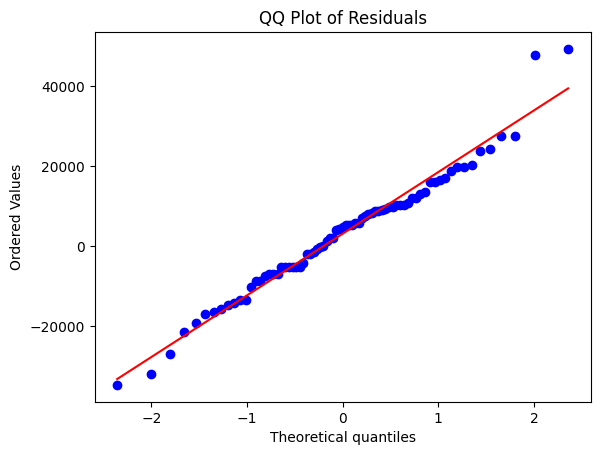

In [13]:
# Make QQ Plot
residuals_2 = np.ravel(y_test_lin - y_pred_lin)
stats.probplot(residuals_2, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()

In [14]:
# Flatten arrays
actual = np.ravel(y_test_lin)
predicted = np.ravel(y_pred_lin)
residuals = actual - predicted

# Create DataFrame
results_df = pd.DataFrame({
    'Actual': actual,
    'Predicted': predicted,
    'Residual': residuals
})

results_df['Index'] = y_test_lin.index

# Sort by absolute residual size
outliers_df = results_df.reindex(results_df['Residual'].abs().sort_values(ascending=False).index)
print(outliers_df.head(5))  # Top 5 outliers


      Actual      Predicted      Residual  Index
22  190000.0  140682.520420  49317.479580     72
42  250000.0  202085.831995  47914.168005     30
1    65000.0   99746.979370 -34746.979370     33
56  170000.0  202085.831995 -32085.831995     93
24  100000.0   72456.618670  27543.381330    256


These don't seem like data entry errors so will keep in dataset.

In [15]:
# Find outlier rows
indices = outliers_df.head(5)['Index'].tolist()
df_encoded.loc[indices, :]

,Age,Job Title,Years of Experience,Salary,Gender_Male,Education Level_Master's,Education Level_PhD
72,45.0,Research Director,16.0,190000.0,1.0,0.0,1.0
30,50.0,CEO,25.0,250000.0,1.0,0.0,0.0
33,39.0,Marketing Specialist,10.0,65000.0,0.0,0.0,0.0
93,52.0,Senior Marketing Manager,25.0,170000.0,0.0,1.0,0.0
256,34.0,Senior Financial Advisor,6.0,100000.0,0.0,1.0,0.0


## Train/Test Split Data (Not Including Age and Job Title)

Age was excluded in linear regression due to multicollinearity, but kept in regularized models since they can manage it.

Job title was likely too noisy and added more variance than signal, which decreased r-squared value.

In [16]:
# Define features (X) and target variable (y)
X = df_encoded.drop(columns = ['Salary', 'Age', 'Job Title'])
y = df_encoded['Salary']

X_train_mlin, X_test_mlin, y_train_mlin, y_test_mlin = train_test_split(X, y, test_size=0.2, random_state=42)

## Predicting Salary with Multiple Linear Regression

Since the simple linear regression model does okay for lower salaries but struggles with higher salary predictions. This indicates that there may be non-linear patterns or features missing that perhaps multiple linear regression can cover.

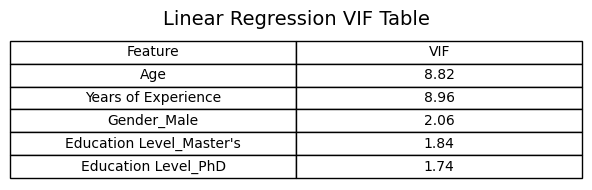

In [17]:
# Select independent variables (excluding target)
X_2 = df_encoded.drop(columns=['Salary'])

# Keep only numeric columns for VIF calculation
X_numeric = X_2.select_dtypes(include=[np.number])

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

# Display sorted VIF values
vif_data.sort_values(by="VIF", ascending=False)

# Create figure and axes
fig, ax = plt.subplots(figsize=(6, 2))

# Hide axes
ax.axis('off')

# Create table
table = ax.table(cellText=round(vif_data, 2).values,
                 colLabels=vif_data.columns,
                 loc='center', cellLoc='center')

# Adjust table properties
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
plt.title("Linear Regression VIF Table", fontsize=14, pad=10)
plt.tight_layout()
plt.show()

### Train the Multiple Linear Regression Model

In [18]:
# Initialize and fit the model
model = LinearRegression()
model.fit(X_train_mlin, y_train_mlin)

LinearRegression()

### Evaluate Multiple Linear Regression Model

Multiple Linear Regression Model (R-Squared: 0.914) performed slightly better than Simple Linear Regression Model (R-Sqaured: 0.899). The mean absolute error is $10,042 (average prediction error), 10% of the average salary.

In [19]:
# Predict Model
y_pred_mlin = model.predict(X_test_mlin)

# Score
mlinear_r2_score = r2_score(y_test_mlin, y_pred_mlin)
mlinear_mae = mean_absolute_error(y_test_mlin, y_pred_mlin)
mlinear_rmse = rmse = np.sqrt(mean_squared_error(y_test_mlin, y_pred_mlin))

print("R²:", mlinear_r2_score)
print("MSE:", mean_squared_error(y_test_mlin, y_pred_mlin))
print("MAE:", mlinear_mae)

R²: 0.9141864321638067
MSE: 205745084.6695178
MAE: 10042.023592161679


In [20]:
# Find the Percent of average salary
mean_absolute_error(y_test_mlin, y_pred_mlin) / df_encoded['Salary'].mean() * 100

np.float64(9.984379193786827)

Holding all else constant,

1.   Having a PhD is associated with $26,144 higher salary compared to the baseline Bachelor's.

2.   Having a Master's is associated with $18,754 higher salary compared to the baseline Bachelor's.

3. Being Male is associated with $6,582 higher salary compared to the baseline being Female.

4. Each year of experience adds on average $5,812 higher salary



In [21]:
# Get model coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
coefficients = coefficients.sort_values(by="Coefficient", ascending=False)  # Sort for better visibility
print(coefficients)


                    Feature   Coefficient
3       Education Level_PhD  26144.335240
2  Education Level_Master's  18754.917817
1               Gender_Male   6582.744498
0       Years of Experience   5812.559747


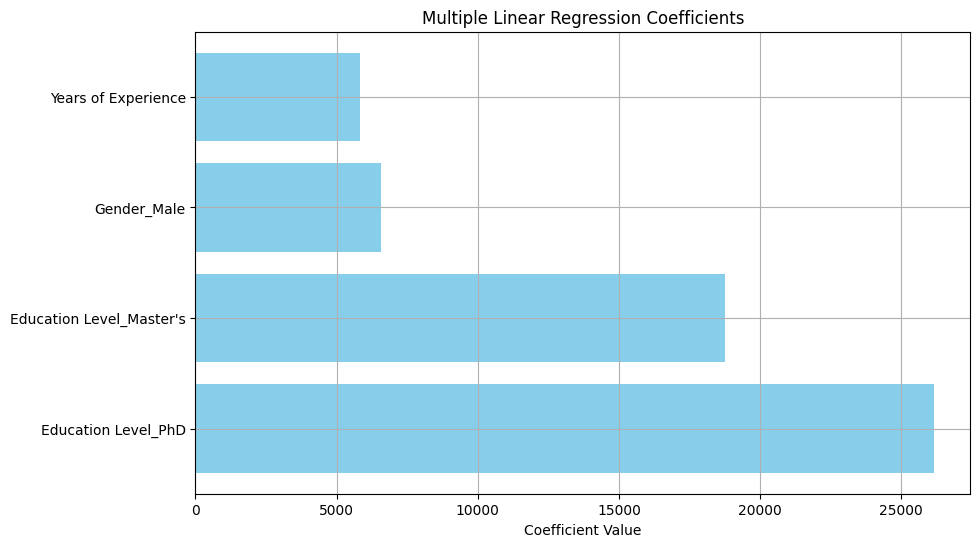

In [22]:
# Plot
plt.figure(figsize=(10, 6))
plt.barh(coefficients['Feature'], coefficients['Coefficient'], color='skyblue')
plt.xlabel("Coefficient Value")
plt.title("Multiple Linear Regression Coefficients")
plt.grid(True)
plt.show()

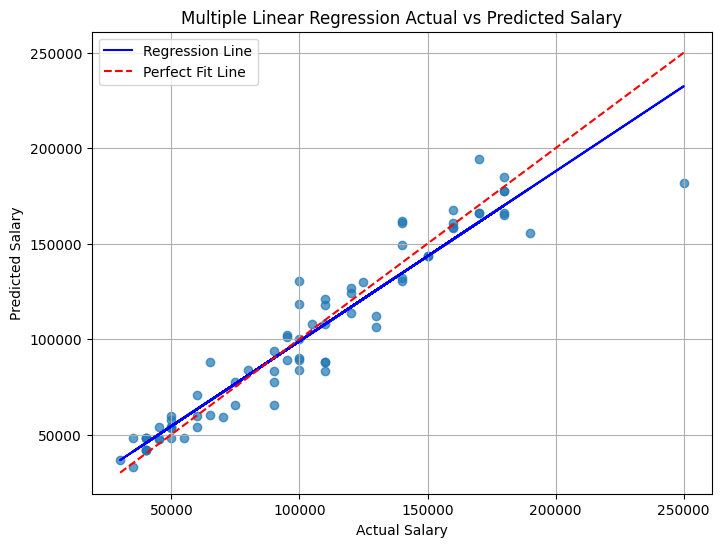

In [23]:
# Dashed line represents the ideal scenario where actual = predicted

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_mlin, y_pred_mlin, alpha=0.7)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Multiple Linear Regression Actual vs Predicted Salary")

# Find Regression and Perfect Fit Line
m, b = np.polyfit(y_test_mlin, y_pred_mlin, 1)
plt.plot(y_test_mlin, m*y_test_mlin + b, color='blue', label='Regression Line')
plt.plot([y_test_mlin.min(), y_test_mlin.max()], [y_test_mlin.min(), y_test_mlin.max()], 'r--', label='Perfect Fit Line')  # perfect fit line
plt.grid(True)
plt.legend()
plt.show()

Variance increases towards the higher end of the salary, but this is expected in salary data.

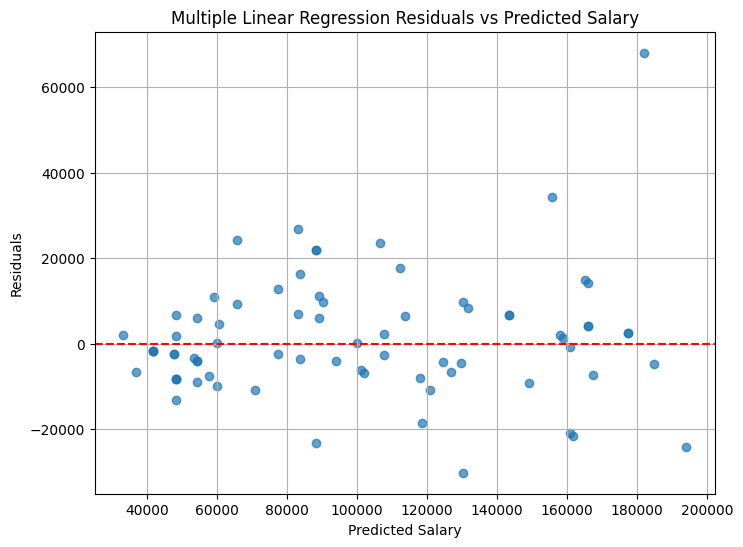

In [24]:
# Find residuals
residuals_mlin = y_test_mlin - y_pred_mlin

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_mlin, residuals_mlin, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Salary")
plt.ylabel("Residuals")
plt.title("Multiple Linear Regression Residuals vs Predicted Salary")
plt.grid(True)
plt.show()

## Compare Multiple Linear Regression Model to Ridge and Lasso Regression

No signs of overfitting:
Test R² is even slightly higher than train R² — not typical, but it can happen due to sample variance.
Test MAE is lower than train MAE — again, this is fine if the test set is slightly easier to predict.

Ridge: Adds penalty for large weights -> stabilizes model.
Lasso: Adds penalty that can zero out unimportant features → performs feature selection.

Since Linear, Ridge, and Lasso regression were pretty similar, this shows that the linear regression model is not overfitted and does not have features that are highly correlated.

In [25]:
# Predictions
y_train_pred = model.predict(X_train_mlin)
y_test_pred = model.predict(X_test_mlin)

# R² scores
r2_train = r2_score(y_train_mlin, y_train_pred)
r2_test = r2_score(y_test_mlin, y_test_pred)

# MAE
mae_train = mean_absolute_error(y_train_mlin, y_train_pred)
mae_test = mean_absolute_error(y_test_mlin, y_test_pred)

print(f"Train R²: {r2_train:.3f}, Test R²: {r2_test:.3f}")
print(f"Train MAE: {mae_train:.2f}, Test MAE: {mae_test:.2f}")


Train R²: 0.890, Test R²: 0.914
Train MAE: 11459.43, Test MAE: 10042.02


Ridge Model (manually pick alpha)

In [26]:
# Fit Ridge Model with manual alpha
ridge_model = Ridge(alpha=1.0)  # You can tune alpha
ridge_model.fit(X_train_mlin, y_train_mlin)

# Predictions
y_ridge_train = ridge_model.predict(X_train_mlin)
y_ridge_test = ridge_model.predict(X_test_mlin)

# Scores
print("Ridge Regression")
ridge_r2_score = r2_score(y_test_mlin, y_ridge_test)
ridge_mae = mean_absolute_error(y_test_mlin, y_ridge_test)
ridge_rmse = rmse = np.sqrt(mean_squared_error(y_test_mlin, y_ridge_test))

print(f"Train R²: {r2_score(y_train_mlin, y_ridge_train):.3f}, Test R²: {ridge_r2_score:.3f}")
print(f"Train MAE: {mean_absolute_error(y_train_mlin, y_ridge_train):.2f}, Test MAE: {ridge_mae:.2f}")


Ridge Regression
Train R²: 0.890, Test R²: 0.915
Train MAE: 11439.62, Test MAE: 9959.40


Lasso Model (manually pick alpha)

In [27]:
# Fit Lasso Model with manual alpha
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train_mlin, y_train_mlin)

# Predictions
y_lasso_train = lasso_model.predict(X_train_mlin)
y_lasso_test = lasso_model.predict(X_test_mlin)

# Scores
print("\nLasso Regression")
print(f"Train R²: {r2_score(y_train_mlin, y_lasso_train):.3f}, Test R²: {r2_score(y_test_mlin, y_lasso_test):.3f}")
print(f"Train MAE: {mean_absolute_error(y_train_mlin, y_lasso_train):.2f}, Test MAE: {mean_absolute_error(y_test_mlin, y_lasso_test):.2f}")



Lasso Regression
Train R²: 0.890, Test R²: 0.914
Train MAE: 11459.05, Test MAE: 10040.97


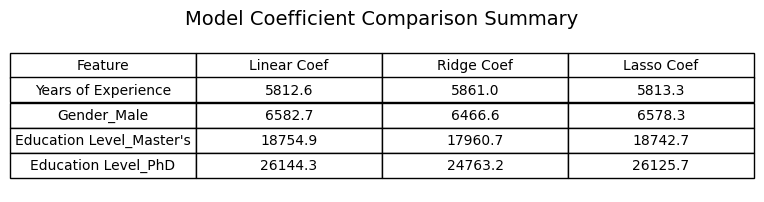

In [28]:
# Create Dataframe
coef_comparison = pd.DataFrame({
    "Feature": X.columns,
    "Linear Coef": model.coef_,
    "Ridge Coef": ridge_model.coef_,
    "Lasso Coef": lasso_model.coef_
})

# Plot as table
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')
table = ax.table(cellText=coef_comparison.round(1).values,
                 colLabels=coef_comparison.columns,
                 loc='center',
                 cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
plt.title("Model Coefficient Comparison Summary", fontsize=14, pad=10)
plt.show()


## Exploring using Lasso regression with Age and Job Title

Lasso gave me slightly lower R², but it helped reduce feature complexity by shrinking less important variables. I’d prefer it if interpretability or generalization is a priority, but if maximizing fit is the goal, multiple linear or Ridge might be better here.

### One Hot Encode Dataframe With all Columns

In [29]:
# Include Job Title along with other categorical variables
categorical_cols = ['Gender', 'Education Level', 'Job Title']

# One-hot encode with drop='first' to reduce multicollinearity
encoder = OneHotEncoder(sparse_output=False, drop= 'first')
encoded_array = encoder.fit_transform(salary[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)

# Convert to DataFrame
encoded_df_2 = pd.DataFrame(encoded_array, columns=encoded_cols, index=salary.index)

# Final feature matrix
X_full = pd.concat([salary.drop(columns=categorical_cols + ['Salary']), encoded_df_2], axis=1)
y = salary['Salary']

full_df = pd.concat([salary.drop(columns=categorical_cols), encoded_df_2], axis=1)
full_df.head()

,Age,Years of Experience,Salary,Gender_Male,Gender_nan,Education Level_Master's,Education Level_PhD,Education Level_nan,Job Title_Accountant,Job Title_Administrative Assistant,...,Job Title_Technical Recruiter,Job Title_Technical Support Specialist,Job Title_Technical Writer,Job Title_Training Specialist,Job Title_UX Designer,Job Title_UX Researcher,Job Title_VP of Finance,Job Title_VP of Operations,Job Title_Web Developer,Job Title_nan
0,32.0,5.0,90000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,28.0,3.0,65000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,45.0,15.0,150000.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,36.0,7.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,52.0,20.0,200000.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train/Test Split Data with All Columns

In [30]:
# Drop NAs
X_full_clean = X_full.dropna()
y_clean = y.loc[X_full_clean.index]  # keep aligned target

# Train/Test Split Data
X_train, X_test, y_train, y_test = train_test_split(X_full_clean, y_clean, test_size=0.2, random_state=42)

In [31]:
# Lasso with cross-validation to find best alpha
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)
y_pred_lasso = lasso_cv.predict(X_test)

# Best alpha found (very different than manual Lasso alpha of 1.0)
print(f"Best alpha: {lasso_cv.alpha_}")

Best alpha: 311.0480890500428


I applied Lasso regression to automatically select the most important predictors of salary. Out of over 150 job titles, only a few remained, including Senior Product Manager and Director of Marketing.

Lasso regression identified a small, interpretable set of features that have the strongest influence on salary. Among these:

Education plays the most significant role:

*   A PhD is associated with a ~$21K increase compared to a Bachelor's degree

*   A Master’s degree boosts salary by ~$16K

Gender has a notable impact:

* Being Male (vs Female) corresponds to a ~$6K increase in predicted salary

Job Title also matters:

* Senior Product Manager stands out with a ~$6K positive contribution

* Other roles (like Director of Marketing) had a smaller but still non-zero effect

Age and Years of Experience both remain in the model despite their correlation, implying they capture distinct, complementary information relevant to salary.

Lasso Regression
Lasso R2: 0.9070601691448644
Lasso MAE: 10284.698796195684
Lasso RMSE: 14927.521100122862


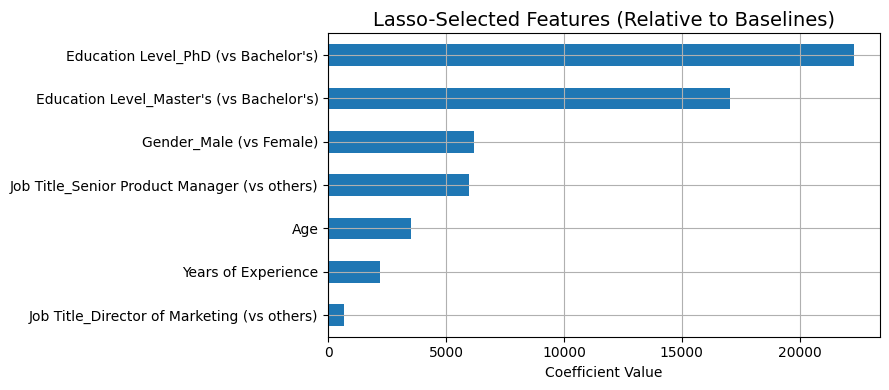

In [32]:
# Extract coefficients and keep only non-zero ones
coef = pd.Series(lasso_cv.coef_, index=X_train.columns)
non_zero_coef = coef[coef != 0].sort_values()

# Mapping from raw one-hot feature names to more readable ones
feature_rename_map = {
    'Gender_Male': 'Gender_Male (vs Female)',
    "Education Level_PhD": "Education Level_PhD (vs Bachelor's)",
    "Education Level_Master's": "Education Level_Master's (vs Bachelor's)",
    'Job Title_Senior Product Manager': 'Job Title_Senior Product Manager (vs others)',
    'Job Title_Director of Marketing': 'Job Title_Director of Marketing (vs others)'}

non_zero_coef = non_zero_coef.rename(index=feature_rename_map)

# Scores
print("Lasso Regression")
lasso_r2_score = r2_score(y_test, y_pred_lasso)
lasso_mae = mean_absolute_error(y_test, y_pred_lasso)
lasso_rmse = rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f'Lasso R2: {lasso_r2_score}')
print(f'Lasso MAE: {lasso_mae}')
print(f'Lasso RMSE: {lasso_rmse}')

# Plot
plt.figure(figsize=(9, 4))
non_zero_coef.plot(kind='barh')
plt.title("Lasso-Selected Features (Relative to Baselines)", fontsize=14)
plt.xlabel("Coefficient Value")
plt.grid(True)
plt.tight_layout()
plt.show()

## Random Forest Regressor

When I used a Random Forest model, feature importance revealed that Age and Years of Experience were by far the strongest predictors of salary. Education had a smaller but still notable impact, and only a few specific job titles contributed meaningfully. This helped me understand that while job title granularity adds some signal, the primary salary drivers are still age and experience.

In [33]:
# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Score
rf_r2_score = r2_score(y_test, y_pred_rf)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest R²: {rf_r2_score:.3f}")
print(f"MAE: {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")

Random Forest R²: 0.902
MAE: 9610.67
RMSE: 15324.52


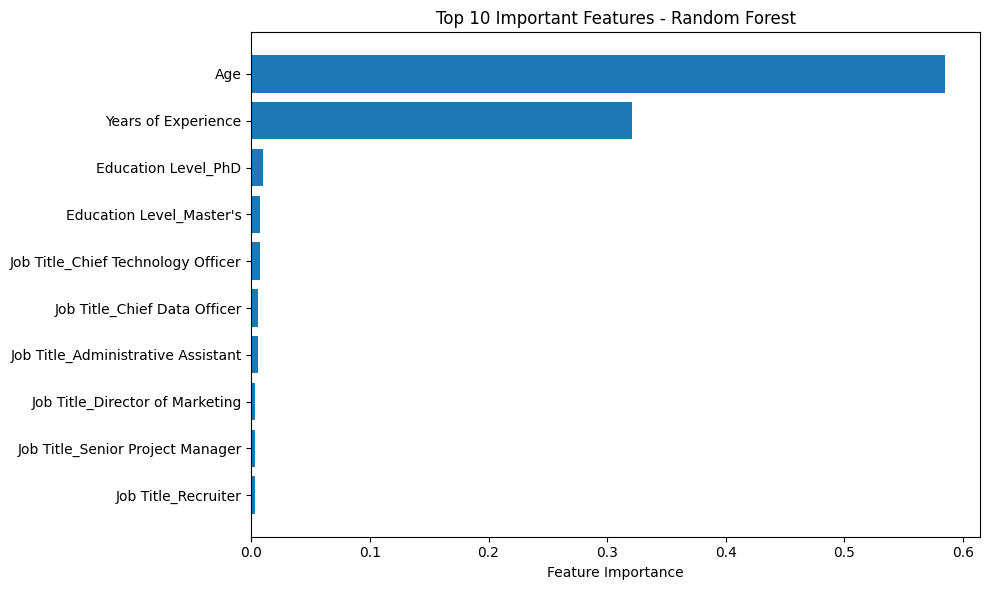

In [34]:
# Create a sorted feature importance DataFrame
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 10
top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'].head(top_n), feature_importances['Importance'].head(top_n))
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Important Features - Random Forest")
plt.gca().invert_yaxis()  # Most important at top
plt.tight_layout()
plt.show()

### SHAP Explanation for one sample

Because job title was one-hot encoded, each title becomes its own binary feature. Only one title is actually ‘on’ per person, but the SHAP plot shows how both the active and inactive titles influence the prediction. Inactive titles may have small negative contributions since the model knows that people with those roles tend to earn less.

This decision plot shows how the model predicted a salary of ~$176K for a 48-year-old with 21 years of experience, a Master’s degree, and a Director-level role. Age and experience were the dominant positive contributors, while not having a PhD or a C-suite title slightly reduced the prediction. Interestingly, gender had a small downward impact, highlighting potential interaction effects in the model.

In [35]:
# Create TreeExplainer for your Random Forest model
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

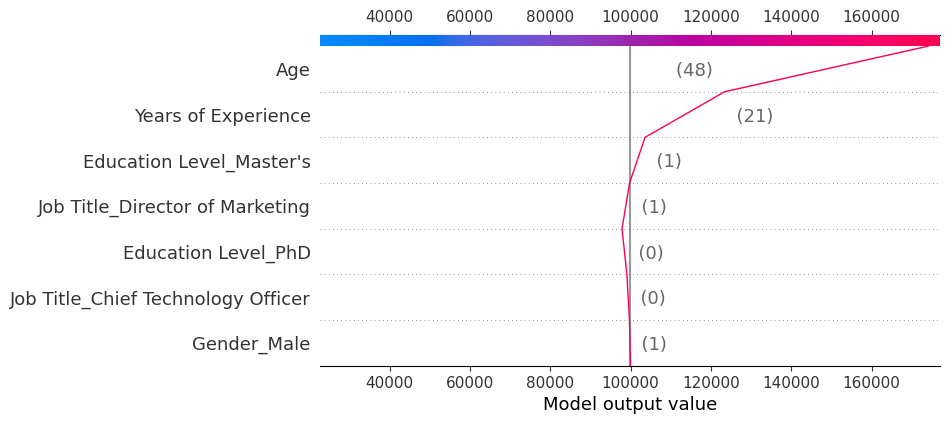

In [36]:
# Get the SHAP values for the selected individual

# Pick a row from X_test
# Grab sample's SHAP values and feature values
sample_idx = 0
shap_vals = shap_values[sample_idx]
feature_vals = X_test.iloc[sample_idx]
feature_names = X_test.columns

# Filter by feature value != 0 or SHAP impact > 500
mask = (feature_vals != 0) | (np.abs(shap_vals) > 500)
top_features_idx = np.argsort(np.abs(shap_vals[mask]))[::-1][:10]

# Decision plot
shap.decision_plot(
    base_value=explainer.expected_value,
    shap_values=shap_vals[mask][top_features_idx],
    features=feature_vals[mask].values[top_features_idx],
    feature_names=feature_vals[mask].index[top_features_idx].tolist()
)


This person is a 36-year-old Senior Business Development Manager with 8 years of experience and no advanced degrees. Their job title contributed positively to the predicted salary, although age and lack of a graduate degree pulled the prediction down.

Unlike the earlier example (a Director with a Master's degree and 21 years of experience), this profile lacks the high-impact linear and tree-based features that typically increase salary.

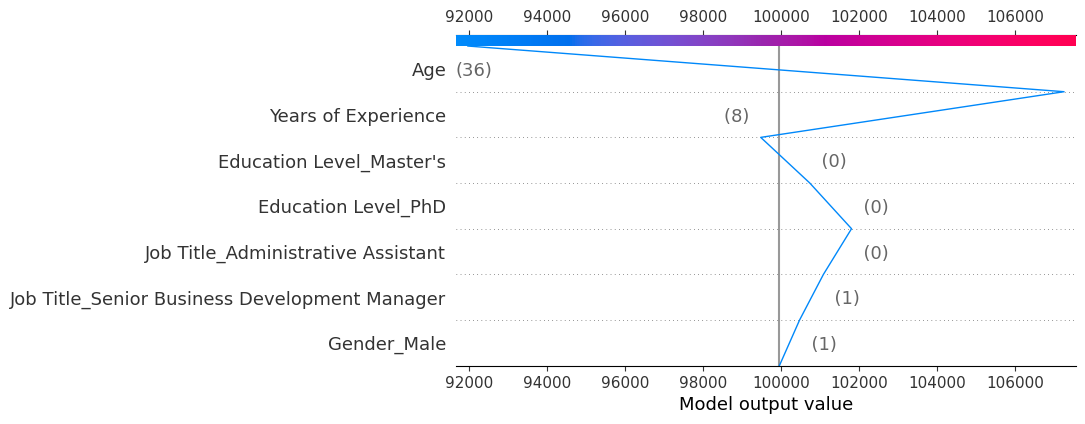

In [37]:
# Get the SHAP values for the selected individual

# Pick a row from X_test
# Grab sample's SHAP values and feature values
sample_idx = -1
shap_vals = shap_values[sample_idx]
feature_vals = X_test.iloc[sample_idx]
feature_names = X_test.columns

# Filter by feature value != 0 or SHAP impact > 500
mask = (feature_vals != 0) | (np.abs(shap_vals) > 500)
top_features_idx = np.argsort(np.abs(shap_vals[mask]))[::-1][:10]

# Decision plot
shap.decision_plot(
    base_value=explainer.expected_value,
    shap_values=shap_vals[mask][top_features_idx],
    features=feature_vals[mask].values[top_features_idx],
    feature_names=feature_vals[mask].index[top_features_idx].tolist()
)

### How does gender impact salary prediction?

To evaluate how the model handled gender, I used SHAP to analyze the contribution of the Gender_Male feature across individuals. The boxplot shows that being male seemed to increase predicted salary, while not being male (i.e., being female) led to slightly lower predictions. The effect wasn't large compared to other features like age or experience, but it was consistent — highlighting a potential gender-based disparity the model learned from the training data.

I conducted a t-test on SHAP values for the Gender_Male feature to assess whether the model systematically attributed different salary predictions based on gender. The result (p-value = 1.206) indicates no significant difference, suggesting that gender was not a key driver of the model's predictions — further supported by its low SHAP importance.

In [38]:
# Assess t-test of cleaned salary data to see if salary is significantly
# different between genders

# Separate salaries by gender
male_salaries = salary_clean[salary_clean['Gender'] == 'Male']['Salary']
female_salaries = salary_clean[salary_clean['Gender'] == 'Female']['Salary']

# Run independent t-test
t_stat, p_value = ttest_ind(male_salaries, female_salaries, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_value)

# Since p-value is > 0.05, I fail to reject the null hypothesis, meaning
# there is no statistically significant difference in average salary
# between males and females at the 5% significance level.

T-statistic: 1.3779803049502477
P-value: 0.16903995657322668


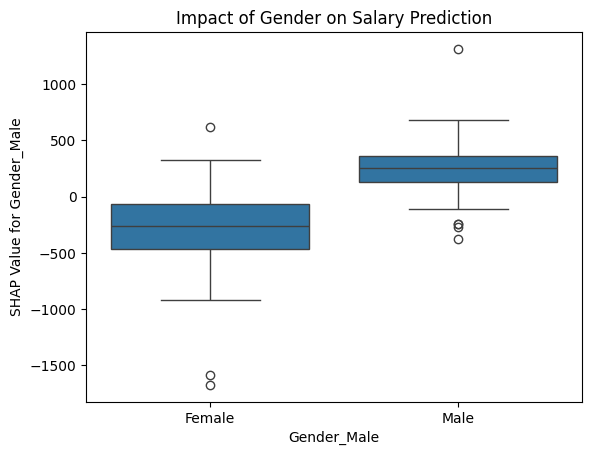

In [39]:
# Create a full SHAP DataFrame for all test samples
shap_df_full = pd.DataFrame(shap_values, columns=X_test.columns, index=X_test.index)
shap_df_full['Gender_Male'].groupby(X_test['Gender_Male']).mean()

# Create boxplot
sns.boxplot(x=X_test['Gender_Male'], y=shap_df_full['Gender_Male'])
plt.xticks([0, 1], ['Female', 'Male'])
plt.ylabel("SHAP Value for Gender_Male")
plt.title("Impact of Gender on Salary Prediction")
plt.show()

In [49]:
# SHAP values for Gender_Male, grouped by actual gender
shap_gender = pd.DataFrame(shap_values, columns=X_test.columns, index=X_test.index)
shap_male = shap_gender.loc[salary_clean['Gender'] == 'Male', 'Gender_Male']
shap_female = shap_gender.loc[salary_clean['Gender'] == 'Female', 'Gender_Male']

# Welch’s t-test
t_stat, p_val = ttest_ind(shap_male, shap_female, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_val)

# Since p-value is > 0.05, I fail to reject the null hypothesis, meaning
# there is no statistically significant difference in average salary
# between males and females at the 5% significance level.

T-statistic: 6.187028248325959
P-value: 1.2058707361131082e-07


## K-Means Clustering

To complement regression-based predictions, I used K-Means clustering as an unsupervised approach to explore patterns in the salary data.
The model identified three distinct employee segments:

Cluster 1: Entry-level professionals with low experience and salary

Cluster 0: Mid-level employees with ~10 years of experience and ~$100K salary

Cluster 2: Highly experienced individuals earning the highest average salary

These clusters help highlight potential career progression paths and could assist in compensation benchmarking or segmentation."

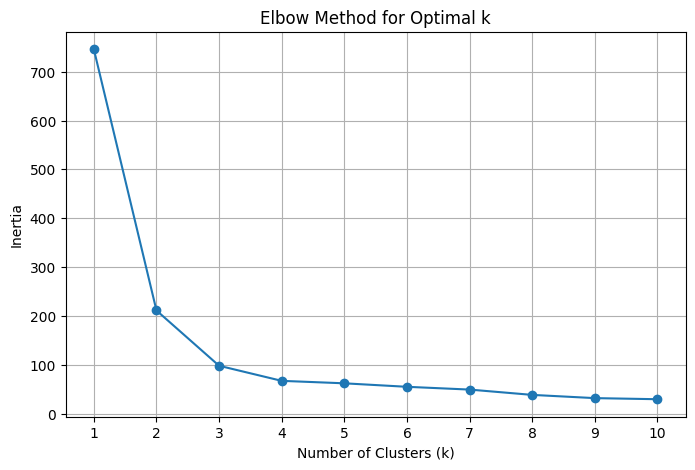

In [41]:
# Copy clean dataframe
clean_df = salary_clean.copy()

# Select relevant features for clustering
cluster_features = clean_df[['Years of Experience', 'Salary']]

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)

# Find best k
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

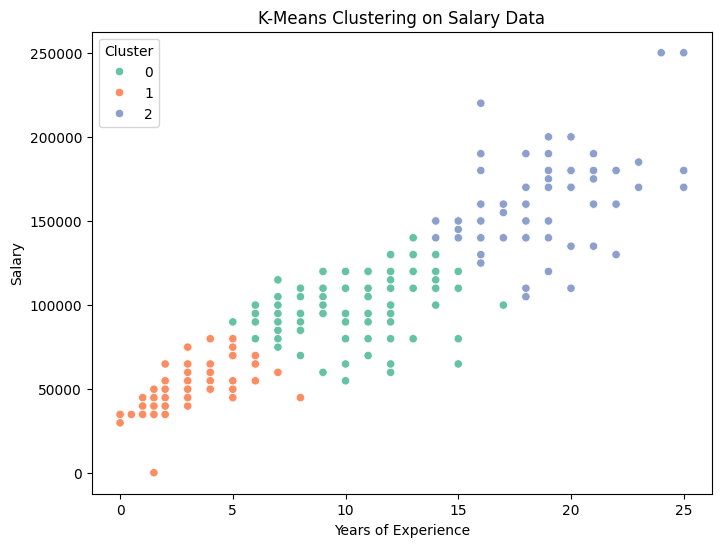

In [42]:
# Fit KMeans with 3 clusters (you can try different values)
kmeans = KMeans(n_clusters=3, random_state=42)
clean_df['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='Years of Experience',
    y='Salary',
    hue='Cluster',
    palette='Set2',
    data=clean_df
)
plt.title('K-Means Clustering on Salary Data')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.legend(title='Cluster')
plt.show()

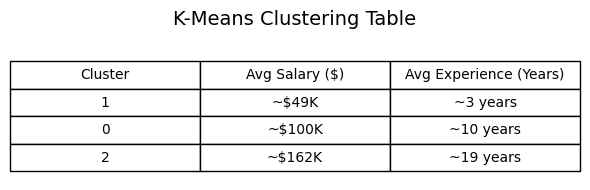

In [43]:
# Find Average Salary and Average Year
df_2 = round(clean_df.groupby('Cluster')[['Salary', 'Years of Experience']].mean().sort_values(by=['Salary']).rename(columns={'Salary': 'Avg Salary ($)', 'Years of Experience': 'Avg Experience (Years)'}).reset_index(), 0)
df_2['Avg Salary ($)'] = df_2['Avg Salary ($)'].apply(lambda x: '~$' + str(int(x/1000)) + 'K')
df_2['Avg Experience (Years)'] = df_2['Avg Experience (Years)'].apply(lambda x: '~' + str(int(x)) + ' years')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust height to fit your content

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axis('off')

# Create the table
table = ax.table(
    cellText=df_2.values,
    colLabels=df_2.columns,
    loc='center',
    cellLoc='center'
)

# Style it
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)  # Wider rows

plt.title("K-Means Clustering Table", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

## Re-run K-Means Clustering with more features

To explore natural groupings in the salary data, I used K-Means clustering and visualized the results using Principal Component Analysis (PCA).

Initially, I included the Job Title for Director of Marketing feature (one-hot encoded and a top job title in the RF model), but it caused PCA to capture only 87% of the variance in the first two principal components. After removing the Job Title, the explained variance increased to 97%, indicating a much more structured and linear relationship among the remaining features.

The final clustering was performed using:

* Years of Experience

* Salary

* Age

* Education Level (Ordinally Encoded)

This approach helped reveal clear cluster separation in the PCA space. Each cluster represents a different segment of professionals, with distinct combinations of experience, education, and compensation.


PC1 is a general experience/salary/age axis:

* High loadings (~0.52) for Years of Experience, Salary, and Age mean that this component captures overall seniority or career progression.

* PC1 is likely the primary driver of cluster separation, with clusters following career stage.

PC2 is strongly dominated by Education Level:

* The high loading (0.898) on Education_Level_Encoded means PC2 primarily captures educational attainment independent of career experience.

* This dimension likely separates individuals who have advanced degrees from those who don’t, even if they are similar in age or salary.

In [44]:
# Choose the features you want to cluster on
clean_df2 = salary_clean.copy()

# Ordinal coding
education_map = {
    "Bachelor's": 0,
    "Master's": 1,
    "PhD": 2
}
clean_df2['Education_Level_Encoded'] = clean_df2['Education Level'].map(education_map)

# Pick the most important Job title from random forest
clean_df2['Job_Title_Director_Marketing'] = (clean_df2['Job Title'] == 'Director of Marketing').astype(int)

# Job Title were chosen based on Lasso Regression and SHAP
cluster_cols = ['Years of Experience', 'Salary', 'Age', 'Education_Level_Encoded']
cluster_features2 = clean_df2[cluster_cols]

# Scale the features
scaler = StandardScaler()
scaled_features2 = scaler.fit_transform(cluster_features2)

# Rerun K-means
kmeans2 = KMeans(n_clusters=3, random_state=42)
clean_df2['Cluster2'] = kmeans2.fit_predict(scaled_features2)

clean_df2.groupby('Cluster2')[cluster_cols].mean().reset_index().rename(columns={'Cluster2': 'Cluster'})

,Cluster,Years of Experience,Salary,Age,Education_Level_Encoded
0,0,10.237410,101043.165468,37.769784,0.316547
1,1,3.096899,49460.077519,29.992248,0.062016
2,2,18.276190,162761.904762,46.123810,1.409524


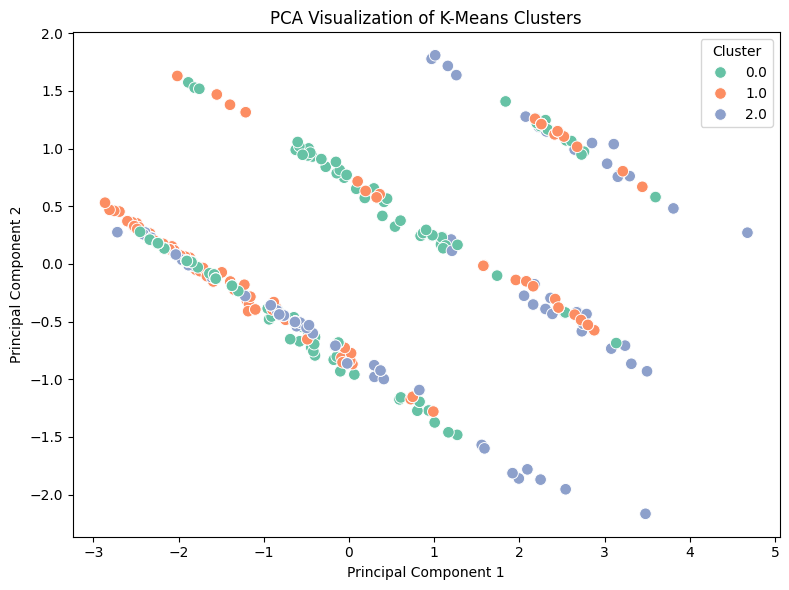


Variance explained by PC1 and PC2: 0.9756542762237042


In [45]:
# Reduce to 2 components for 2D plotting
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features2)

# Convert to DataFrame for clarity
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clean_df2['Cluster2']  # Add cluster labels

# Plot the PCA result with cluster labels
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster',
    palette='Set2',
    data=pca_df,
    s=70
)
plt.title('PCA Visualization of K-Means Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()
print("\nVariance explained by PC1 and PC2:", pca.explained_variance_ratio_.sum())

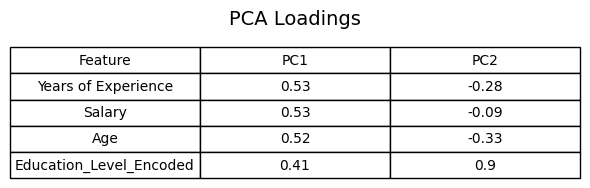

In [46]:
# After fitting PCA
pca = PCA(n_components=2)
pca_components = pca.fit(scaled_features2)

# Get component loadings (aka eigenvectors)
loadings = round(pd.DataFrame(
    pca_components.components_.T,
    columns=['PC1', 'PC2'],
    index=cluster_features2.columns
), 2).reset_index().rename(columns = {'index': 'Feature'})

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust height to fit your content

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axis('off')

# Create the table
table = ax.table(
    cellText=loadings.values,
    colLabels=loadings.columns,
    loc='center',
    cellLoc='center'
)

# Style it
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)  # Wider rows

plt.title("PCA Loadings", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Comparing all Supervised Models

Note the difference in feature selection:

* Simple Linear Regression only took into consideration Years of Experience and Salary.

* Multiple Linear Regression and Ridge Regression had a few features removed. Job Title was removed due to the increase in variance it added. Age was removed due to its multicollinearity to Years of Experience.

* Age and Job Title were added back in for the remaining models.



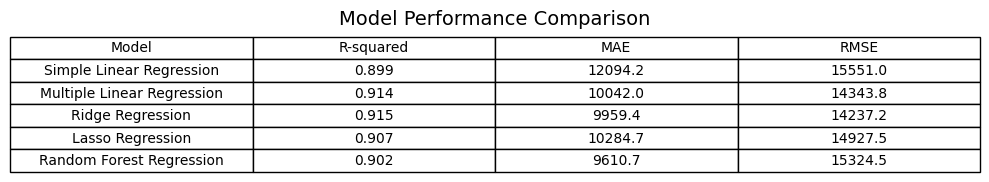

In [47]:
df = pd.DataFrame({
    'Model': ['Simple Linear Regression', 'Multiple Linear Regression',
              'Ridge Regression', 'Lasso Regression',
              'Random Forest Regression'],
    'R-squared': [round(linear_r2_score, 3), round(mlinear_r2_score, 3),
                  round(ridge_r2_score, 3), round(lasso_r2_score, 3),
                  round(rf_r2_score, 3)],
    'MAE': [round(linear_mae, 1), round(mlinear_mae, 1),
            round(ridge_mae, 1), round(lasso_mae, 1),
            round(rf_mae, 1)],
    'RMSE': [round(linear_rmse, 1), round(mlinear_rmse, 1),
             round(ridge_rmse, 1), round(lasso_rmse, 1),
             round(rf_rmse, 1)]
})

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 2))  # Adjust height to fit your content

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axis('off')

# Create the table
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    loc='center',
    cellLoc='center'
)

# Style it
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)  # Wider rows

plt.title("Model Performance Comparison", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Conclusion

This project explored the key factors that influence salary using multiple modeling techniques.

I chose to perform further analysis with Lasso Regression over Ridge, since Lasso performs feature selection by zeroing out less important coefficients — which was especially useful given the high dimensionality introduced by one-hot encoding over 150 job titles.

- **Linear and Lasso Regression** identified `Education_Level_Master's` as the strongest linear predictor of salary, likely due to its clean signal and lack of multicollinearity.
- **Random Forest** highlighted `Age` and `Years of Experience` as top features, revealing non-linear patterns and interaction effects not captured by linear models.
- **SHAP analysis** allowed for deeper interpretability, confirming model reasoning at both the global and individual level.

In addition, I explored the impact of gender on model predictions. SHAP values showed that gender had a small but consistent effect, which was not statistically significant. This does not imply bias in the model, but rather reflects patterns in the data — potentially due to how gender interacts with features like job title, education, and experience. It serves as a reminder that SHAP reveals model behavior, not necessarily fairness or societal truth. Further analysis with a more balanced or enriched dataset would be needed to confirm any bias.

This comparison also emphasizes how model choice shapes interpretability. Linear models offer transparent coefficients but may miss complex patterns. Tree-based models capture richer interactions but require tools like SHAP for interpretability.

While supervised models like Lasso and Random Forest aimed to predict salary directly, I also explored K-Means clustering to see how the data naturally groups, visualized through PCA. This helped confirm that individuals with higher education and experience clustered into higher salary groups, consistent with model predictions.

Future improvements could include additional feature grouping (e.g., job title categories), hyperparameter tuning, or testing alternative models such as XGBoost or gradient boosting machines.

In [48]:
# !pip freeze > requirements.txt